In [140]:
import importlib
import os
import subprocess
import pandas as pd
import platform
import pathlib
import requests
from io import StringIO
import numpy as np
from annotations import *
from extract_video_features import *
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics import f1_score
import extract_video_features
importlib.reload(extract_video_features)
from extract_video_features import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [4]:
filename_annotations = 'https://docs.google.com/spreadsheets/d/1Rqu1sJiD-ogc4a6R491JTiaYacptOTqh6DKqhwTa8NA/gviz/tq?tqx=out:csv&sheet=Template'

features_folder = 'C:/Users/vince/Documents/TELECOM/Fil_Rouge/OpenFace/OpenFace_2.2.0/processed/'
video_folder = 'C:/Users/vince/Documents/TELECOM/Fil_Rouge/VideoAFPA'

In [5]:
video_names = [x.replace('.mp4','') for x in os.listdir(video_folder)]
video_names.remove('WIN_20210329_14_13_45_Pro')
video_names.remove('WIN_20210403_18_49_15_Pro')
video_names.remove('WIN_20210402_14_27_50_Pro')
#video_names.remove('WIN_20210407_15_02_22_Pro')

video_names = [sub.replace('.txt', '') for sub in video_names]

In [6]:
features_to_keep = [
'frame','face_id','timestamp','confidence','success',

'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r',
'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c',

'gaze_0_x','gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
'gaze_angle_x', 'gaze_angle_y', 
'pose_Tx', 'pose_Ty', 'pose_Tz','pose_Rx', 'pose_Ry', 'pose_Rz',

'type_candidat','sexe','video_name','stress_global','stress','diapo'
]

In [7]:
list_df = []
aggreg = 'mean'
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations(features_folder, v_name, filename_annotations,aggreg)[features_to_keep]
    list_df.append(df_annoted)

100%|██████████| 28/28 [01:21<00:00,  2.90s/it]


In [8]:
to_drop = ['frame','face_id','timestamp','confidence','success']

list_df_with_dist=[]
for i in tqdm(list_df):
    l=add_dist_features(i)
    l.drop(to_drop,axis='columns', inplace=True)
    list_df_with_dist.append(l)

groupby_features = ['video_name','stress_global','stress','diapo','type_candidat','sexe','dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x','dist_pose_y', 'dist_pose_z' ]

df = pd.concat(list_df_with_dist)
#df = df.groupby(groupby_features).mean().reset_index()
df = df.groupby(groupby_features).agg({'mean','std'}).reset_index()
df.columns = df.columns.map('_'.join).str.strip('_')
df

100%|██████████| 28/28 [02:53<00:00,  6.18s/it]


,video_name,stress_global,stress,diapo,type_candidat,sexe,dist_head,dist_gaze_0,dist_gaze_1,dist_pose_x,...,AU23_c_mean,AU23_c_std,AU25_c_mean,AU25_c_std,AU26_c_mean,AU26_c_std,AU28_c_mean,AU28_c_std,AU45_c_mean,AU45_c_std
0,Test_pour_AFPA,0,0,1,Stagiaire,H,35.959408,0.525630,0.567888,0.120576,...,0.451176,0.497659,0.122941,0.328402,0.261569,0.439532,0.006078,0.077735,0.212549,0.409151
1,Test_pour_AFPA,0,0,8,Stagiaire,H,48.434374,0.671260,0.852326,0.170973,...,0.172000,0.377506,0.650667,0.476918,0.780667,0.413933,0.010000,0.099532,0.544667,0.498167
2,Test_pour_AFPA,0,0,9,Stagiaire,H,44.467469,0.621534,0.705981,0.145665,...,0.358249,0.479567,0.531987,0.499060,0.850168,0.356966,0.027946,0.164846,0.417845,0.493287
3,Test_pour_AFPA,0,0,10,Stagiaire,H,41.696521,0.562944,0.645913,0.136381,...,0.292537,0.455041,0.502488,0.500118,0.581095,0.493503,0.009453,0.096789,0.324378,0.468259
4,Test_pour_AFPA,0,0,11,Stagiaire,H,46.746221,0.683707,0.727095,0.180677,...,0.352778,0.477917,0.412847,0.492431,0.295139,0.456184,0.004167,0.064426,0.370139,0.482926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,WIN_20210417_14_53_12_Pro,0,0,10,Stagiaire,F,45.825063,0.949746,1.151113,0.175213,...,0.933499,0.249218,0.145409,0.352601,0.132506,0.339124,0.000000,0.000000,0.159305,0.366051
220,WIN_20210417_14_53_12_Pro,0,0,11,Stagiaire,F,44.743198,0.942931,1.105028,0.179020,...,0.930055,0.255098,0.131579,0.338091,0.074792,0.263101,0.003809,0.061609,0.168629,0.374489
221,WIN_20210417_14_53_12_Pro,0,0,17,Stagiaire,F,57.926143,0.837893,1.217370,0.200221,...,0.994266,0.075549,0.266055,0.442147,0.331422,0.470995,0.049312,0.216643,0.232798,0.422857
222,WIN_20210417_14_53_12_Pro,0,1,12,Stagiaire,F,53.671493,0.925096,1.154474,0.151404,...,0.741949,0.437607,0.183732,0.387306,0.107969,0.310373,0.001032,0.032115,0.124690,0.330402


In [154]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat','sexe'],axis=1)
#Replace string values
#x.sexe = x.sexe.replace('H',0)
#x.sexe = x.sexe.replace('F',1)
y = df[['stress']]

#Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

## Ordinal Classification

In [157]:
import ordinal_classification as o_c
importlib.reload(o_c)

model1 = RandomForestClassifier(random_state = 42)
model2 = RandomForestClassifier(random_state = 42)
list_models = [model1, model2]
y_preds = o_c.ordinal_classification(list_models, x_train, y_train, x_test)
y_preds

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0], dtype=int64)

In [158]:
cm = confusion_matrix(y_test, y_preds)
print("F1 score = ", f1_score(y_test, y_preds, average='weighted'))

F1 score =  0.6305593321465599


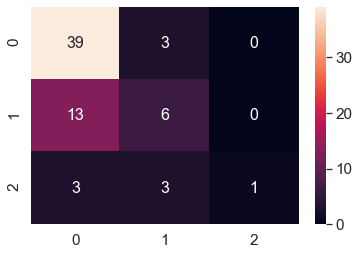

In [151]:
df_cm = pd.DataFrame(cm, range(3), range(3))
#plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## Classic prediction

In [152]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

model = RandomForestClassifier(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
print('RMSE = ',rmse)
print("F1 score = ", f1_score(y_test, y_pred, average='weighted'))

RMSE =  0.6751906048969998
F1 score =  0.638391265597148


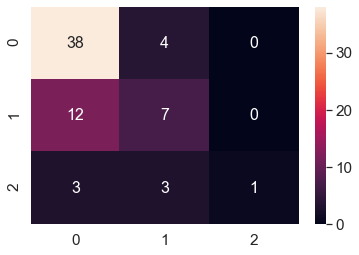

In [153]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(3), range(3))
#plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [86]:
t_d1 = ['dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x',
       'dist_pose_y', 'dist_pose_z']

t_d2 = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
       'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r',
       'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

t_d3 = ['AU01_c', 'AU02_c', 'AU04_c',
       'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c',
       'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c',
       'AU45_c']

t_d4 = ['sexe']

In [105]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


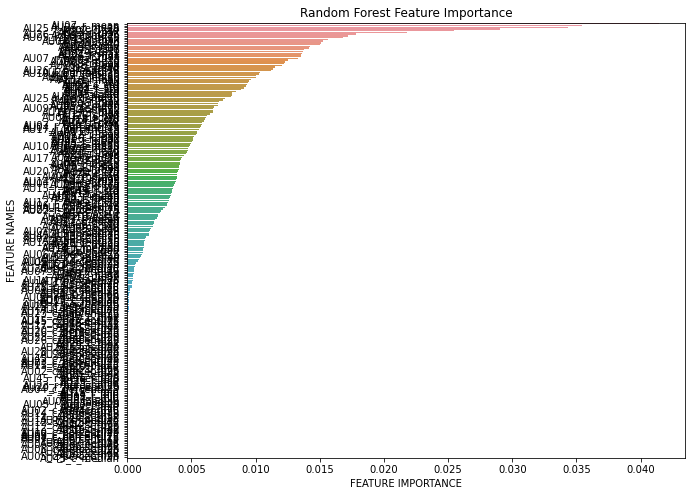

In [131]:
plot_feature_importance(model.feature_importances_,x_train.columns,'Random Forest') 

In [ ]:
AU / dist / sexe